<a href="https://colab.research.google.com/github/musicjae/NLP/blob/master/NPLM(2003).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. INTRO  

&nbsp;&nbsp;&nbsp;&nbsp;확률적 언어 모델NPLM(Neural Probabilistic Language Model)은 이전 word sequences를 통해 다음 word sequences를 예측하는 것이다. (이것은 최근들어 'NNLM (Neural Networks Language Models)라고 불리기도 한다.)


## 1.1 도입 동기  
  
언어 모델링을 어렵게 만드는 문제: **차원의 저주** 언어 모델링에서, #(Input words)가 증가하면,  #(Param)은 기하급수적으로 커진다. 이 곤경은 기존의 **원-핫 인코딩** 방법에서 자주 나타난다.  


### 1.1.1 원핫 인코딩  
  
&nbsp;&nbsp;&nbsp;&nbsp;일종의 Discrete representation(혹은 Localist representation)인 원핫 인코딩은 각 단어에 인덱스를 부여하는 희소 벡터를 할당하는 방법이다. 단어 집합(vocabulary) --- which is 서로 다른 단어들의 집합 --- 안에 아래 같이 3 개의 words가 있다고 해보자.  

사과: [1 0 0]  
배: [0 1 0]  
복숭아: [0 0 1]  

In [22]:
# For 1.1.1

import numpy as np

words = ['사과','배','복숭아']
onehot_vectors = []

for i in range(len(words)):

    onehot_vectors.append(i)


for i in range(len(onehot_vectors)):

    print( (words[i], np.eye(len(onehot_vectors))[i]))

('사과', array([1., 0., 0.]))
('배', array([0., 1., 0.]))
('복숭아', array([0., 0., 1.]))


### 1.1.2 원핫 인코딩이 가진 곤경  
  
(1) 원핫 인코딩에서, Input words의 수가 크게 늘어난다면, 가령 그 수가 1 만개라면, 각각의 단어 벡터들은 희소 벡터 형태를 가진 1 만 차원의 벡터가 되는데, 이것은 메모리 효율과 계산 복잡도 차원에서 비효율적이다.  우리는 Input words의 개수가 늘어나더라도 더 효율적으로 이 words를 처리할 필요가 있다.
  
(2) 원핫 인코딩의 경우에, 단어들의 유사성을 비교하기 어렵다. 위 사례에서 보듯이, 두 개의 단어 벡터들 간의 dot product는 항상 0 이기 때문이다. 이 사실은 두 벡터 간의 cosine 관계가 직교 orthogonal 하다는 것을 의미하고, 이는 두 원핫 벡터가 서로 연관이 없다는 것을 함의한다. 하지만 이것은 문제적이다. 왜냐하면 각 벡터와 연결된 단어들 간의 상관성이 있을 수 있기 때문이다. 우리는 단어 '강아지'와 '고양이'가 서로 금수라는 측면에서 유사하다고 간주할 수 있고, 단어 '낙관적인'과 '비관적인'은 서로 반의어 관계에 있다는 것을 받아들일 수 있다.

In [25]:
# For 1.1.2.(2)
a = [1, 0,0]
b=[0,1,0]
result = 0

for i in range(3):

    result += a[i]*b[i]

print(result)

0


## 1.2 분산 표현 Distributed Representations  
  
본고에서는 분산 표현을 통해 언어 모델링을 하고자 한다. 즉, 이것은 분산 표현을 통해 이전 단어 시퀀스를 가지고 다음에 나올 단어 시퀀스를 예측하고자 한다. 여기서 분산 표현을 사용하는 이유는 이것을 도입하면 기존의 언어 모델링 때 나타나는 차원의 저주가 다소 해소되고, 뿐만 아니라 단어들 간의 유사성 비교도 가능해지기 때문이다.  
분산 표현 distributed representations은 -- 원핫 인코딩 경우와 같이 단어와 벡터 간의 one to one 관계가 아닌 -- 이들 간의 many to many 관계에 의해 표현된다. 즉, 분산 표현에서는 어떤 단일의 concept(word)의 표현이라도 여러 processing units에 대해 분포된다. 대개 이 units의 벡터값은 1, 0 이 아닌 연속적인 값(실수)이다. 이것은 소위 'anti-localist'라 불리는 connectionist (McClelland, Hinton etc)에 의해 옹호되었다. 아래 그림은 분산 표현에 대한 사례를 보여준다.  


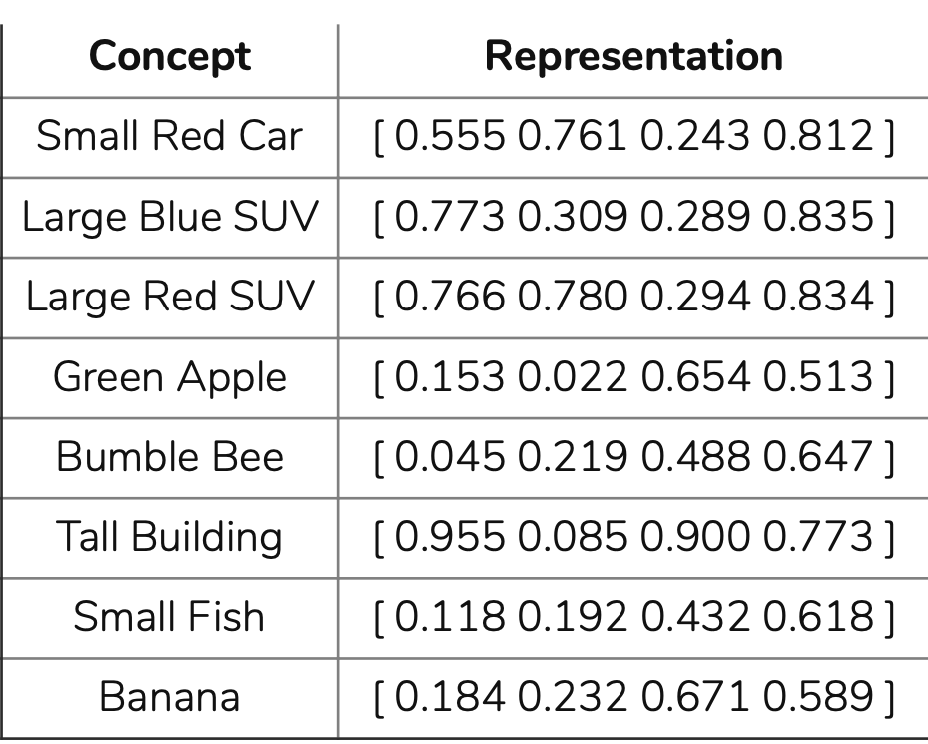

이 분산 표현을 이용하면 우리는 1.1.2에서 살펴보았던 원핫 인코딩(localist 표현)이 갖는 2 가지 곤경을 모두 어느 정도 해소할 수 있다.  
  
(1') 분산 표현에서는 words가 사상된 (processing unit vectors인) **word feature vectors**을 통해 단어 시퀀스의 **결합 확률 함수 joint probability function**를 표현한다. 이것은 words와 feature vectors가 many to many 관계에 있게 만들어 준다. 이것이 차원의 저주를 해소하는 까닭은 Feature vecotors의 수가 words의 수보다 훨씬 작기 때문이다. 이 Feature vectors는 단어의 여러 측면을 표현하기 때문에 원핫 인코딩 경우처럼 words의 수에 비례한 많은 unit vector를 필요로 하지 않는다.  
  
(2') 분산 표현에서는 단어 간의 유사도를 비교할 수 있다. 원핫 인코딩에서는 가령 '곰'과 '사자'가 유사한 정도와 '사자'와 '바나나'가 유사한 정도가 같았다면, 분산 표현에서는 이제 그렇지 않다. 위의 사례 그림을 볼 때, 우리는 Red SUV와 Blue SUV의 유사성 정도는 그것들과 Small Fish 간의 유사성 정도 보다 더 크다는 것을 알 수 있다.

# Reference  
[1] Bengio, Yoshua, et al. "A neural probabilistic language model." Journal of machine learning research 3.Feb (2003): 1137-1155.  
[2] https://wikidocs.net/22647  
[3] https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/03/29/NNLM/  
[4] https://www.districtdatalabs.com/nlp-research-lab-part-1-distributed-representations 분산 표현이 무엇인지에 대한 흥미로운 사고 실험을 소개한다.  

[5] 